# Recommendation Movie
![film](./film.jpg)
membuat model rekomendasi untuk memberikan saran kepada pengguna. dataset yang digunakan berasal dari kaggle, berikut adalah linknya:
https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset?select=filmtv_movies.csv

# Import Library

In [235]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

# Upload cvs

In [236]:
df = pd.read_csv('filmtv_movies.csv')

df.head(5)

,filmtv_id,title,year,genre,duration,country,directors,actors,avg_vote,critics_vote,public_vote,total_votes,description,notes,humor,rhythm,effort,tension,erotism
0,2,Bugs Bunny's Third Movie: 1001 Rabbit Tales,1982,Animation,76,United States,"David Detiege, Art Davis, Bill Perez",NaN,7.7,8.00,7.0,22,"With two protruding front teeth, a slightly sl...","These are many small independent stories, whic...",3,3,0,0,0
1,3,18 anni tra una settimana,1991,Drama,98,Italy,Luigi Perelli,"Kim Rossi Stuart, Simona Cavallari, Ennio Fant...",6.5,6.00,7.0,4,"Samantha, not yet eighteen, leaves the comfort...","Luigi Perelli, the director of the ""Piovra"", o...",0,2,0,2,0
2,17,Ride a Wild Pony,1976,Romantic,91,United States,Don Chaffey,"Michael Craig, John Meillon, Eva Griffith, Gra...",5.7,6.00,5.0,10,"In the Australia of the pioneers, a boy and a ...","""Ecological"" story with a happy ending, not wi...",1,2,1,0,0
3,18,Diner,1982,Comedy,95,United States,Barry Levinson,"Mickey Rourke, Steve Guttenberg, Ellen Barkin,...",7.0,8.00,6.0,18,Five boys from Baltimore have a habit of meeti...,A cast of will be famous for Levinson's direct...,2,2,0,1,2
4,20,A che servono questi quattrini?,1942,Comedy,85,Italy,Esodo Pratelli,"Eduardo De Filippo, Peppino De Filippo, Clelia...",5.9,5.33,7.0,15,"With a stratagem, the penniless and somewhat p...",Taken from the play by Armando Curcio that the...,3,1,1,0,0


In [237]:
# cek baris dan kolom
df.shape

(41399, 19)

In [238]:
#cek info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41399 entries, 0 to 41398
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filmtv_id     41399 non-null  int64  
 1   title         41399 non-null  object 
 2   year          41399 non-null  int64  
 3   genre         41304 non-null  object 
 4   duration      41399 non-null  int64  
 5   country       41389 non-null  object 
 6   directors     41365 non-null  object 
 7   actors        39272 non-null  object 
 8   avg_vote      41399 non-null  float64
 9   critics_vote  36703 non-null  float64
 10  public_vote   41205 non-null  float64
 11  total_votes   41399 non-null  int64  
 12  description   39857 non-null  object 
 13  notes         18797 non-null  object 
 14  humor         41399 non-null  int64  
 15  rhythm        41399 non-null  int64  
 16  effort        41399 non-null  int64  
 17  tension       41399 non-null  int64  
 18  erotism       41399 non-nu

terdapat 19 kolom dengan detail informasi :
1. 9 kolom dengan tipe data int64, kolom tersebut adalah:
    - `filmtv_id`: key feature dari film tv yang diambil dari website
    - `year`: tahun muncul film
    - `duration`: lama waktu durasi film dalam menit
    - `total_votes`: jumlah vote dari critics dan public
    - `humor`: skor untuk movie humor dari filmtv
    - `rhythm`: skor untuk ritme movie dari filmtv
    - `effort`: skor untuk effort movie dari filmtv
    - `tension`: skor untuk tensi movie dari filmtv
    - `erotism`: skor untuk nilai erotis dalam movie dari filmtv
2. 7 kolom dengan tipe data object, kolom tersebut adalah:
    - `title`: judul original untuk movie
    - `genre`: genre dari movie
    - `country`: negara tempat memproduksi movie
    - `directors`: nama dari direktor movie tersebut
    - `actors`: nama dari aktor movie
    - `description`: deskripsi dari movie
    - `notes`: info tambahan unutk movie
3. 3 kolom dengan tipe data float64, kolom tersebut adalah:
    - `avg_vote`: nilai rata-rata rating dari critics dan public
    - `critics_vote`: nilai rata-rata dari critics
    - `public_vote`: nilai rata-rata vote dari public

# Exploratory Data Analysis
Pengambilan beberapa feature. kita akan mengambil beberapa feature saja untuk membangun model sistem rekomendasi. feature yang akan kita gunakan adalah `title`, `avg_vote`, `filmtv_id`, `genre`, dan, `directors`. feature tersebut digunakan untuk membangun model *content based filtering* dan *collaborative filtering*. untuk detail informasi adalah:
1. *Content based filtering* menggunakna feature:
    - title
    - genres
2. *Collaborative filtering* menggunakan feature:
    - title
    - avg_vote

visualisasi dari avg_vote

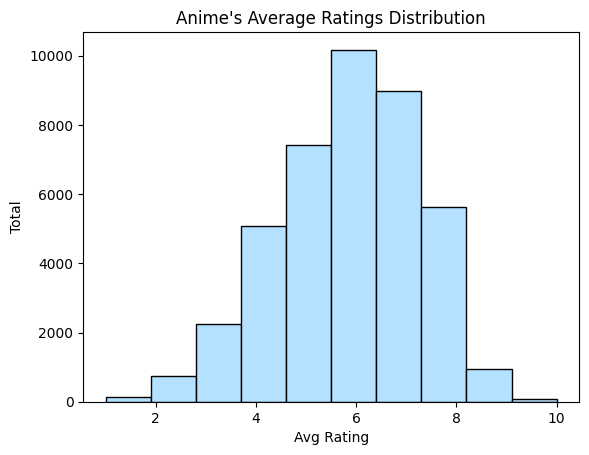

In [239]:
plt.hist(df.avg_vote, color='#B4E1FF', edgecolor='black')
plt.ylabel('Total')
plt.xlabel('Avg Rating')
plt.title("Anime's Average Ratings Distribution")
plt.show()

mengecek informasi detail tiap feature

In [240]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
filmtv_id,41399.0,57746.410179,59962.095730,2.0,15857.00,36266.0,70935.0,232920.0
year,41399.0,1993.505302,23.685612,1897.0,1976.00,2001.0,2013.0,2023.0
duration,41399.0,100.537163,27.260962,41.0,90.00,96.0,107.0,1525.0
avg_vote,41399.0,5.801522,1.403861,1.0,4.80,5.9,6.9,10.0
critics_vote,36703.0,5.796077,1.593062,1.0,4.67,6.0,7.0,10.0
public_vote,41205.0,5.924135,1.480112,1.0,5.00,6.0,7.0,10.0
total_votes,41399.0,36.986763,69.386853,1.0,5.00,12.0,36.0,1082.0
humor,41399.0,0.577381,0.899402,0.0,0.00,0.0,1.0,5.0
rhythm,41399.0,1.345347,1.154829,0.0,0.00,2.0,2.0,5.0
effort,41399.0,0.684847,1.112334,0.0,0.00,0.0,1.0,5.0


Fungsi `describe()` memberikan informasi statistik pada masing-masing kolom, antara lain:

- `Count` adalah jumlah sampel pada data.
- `Mean` adalah nilai rata-rata.
- `Std` adalah standar deviasi.
- `Min` yaitu nilai minimum setiap kolom.
- `25%` adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- `50%` adalah kuartil kedua, atau biasa juga disebut median (nilai tengah). - 75% adalah kuartil ketiga.
- `Max` adalah nilai maksimum.

pengecekan jumlah nilai duplikat

In [241]:
df.duplicated().sum()

np.int64(0)

tidak ada data yang duplikat

selanjutnya, mengecek apakah ada data kosong

In [242]:
df.isnull().sum()

filmtv_id           0
title               0
year                0
genre              95
duration            0
country            10
directors          34
actors           2127
avg_vote            0
critics_vote     4696
public_vote       194
total_votes         0
description      1542
notes           22602
humor               0
rhythm              0
effort              0
tension             0
erotism             0
dtype: int64

ternyata terdapat banyak nilai null pada dataframe

# Data Preprocessing

mengambil feature yang digunakan saja

In [243]:
# mengambil beberapa feature saja
df_set = df[['title', 'avg_vote', 'filmtv_id', 'genre', 'directors','description']].copy()

mengecek feature apa yang kosong

In [244]:
df_set.isnull().sum()

title             0
avg_vote          0
filmtv_id         0
genre            95
directors        34
description    1542
dtype: int64

menghapus nilai yang hilang

In [245]:
df_set.dropna(inplace=True)
print(df_set.shape)

(39742, 6)


mengecek ulang data

In [246]:
df_set.isnull().sum()

title          0
avg_vote       0
filmtv_id      0
genre          0
directors      0
description    0
dtype: int64

mengecek informasi dari genre

In [247]:
df_set.genre.unique()

array(['Animation', 'Drama', 'Romantic', 'Comedy', 'Spy', 'Crime',
       'Thriller', 'Adventure', 'Documentary', 'Horror', 'Action',
       'Western', 'Biography', 'Musical', 'Sci-Fi', 'War', 'Grotesque',
       'Gangster', 'Fantasy', 'Mélo', 'Mythology', 'History', 'Erotico',
       'Noir', 'Super-hero', 'Biblical', 'Sport', 'Sperimental',
       'Short Movie', 'Stand-up Comedy'], dtype=object)

mengecek informasi dari directors

In [248]:
df_set.directors.unique().tolist()[:10]

['David Detiege, Art Davis, Bill Perez',
 'Luigi Perelli',
 'Don Chaffey',
 'Barry Levinson',
 'Esodo Pratelli',
 'Gianfranco Baldanello, Menahem Golan',
 'Elio Petri',
 'John Frankenheimer',
 'Ray Morrison (Angelo Dorigo)',
 'James Foley']

In [249]:
# Menghapus baris yang memiliki lebih dari satu director (ditandai dengan koma di kolom 'directors')
df_set = df_set[~df_set['directors'].str.contains(',', na=False)]
df_set.shape

(37631, 6)

mengambil feature yang digunakna untuk membuat model content based filtering

In [250]:
df_cbf = pd.DataFrame({
    'filmtv_id': df_set['filmtv_id'],
    'title': df_set['title'],
    'genre': df_set['genre'],
    'description': df_set['description'].apply(lambda x: x.lower().strip())
})
df_cbf.head(5)

,filmtv_id,title,genre,description
1,3,18 anni tra una settimana,Drama,"samantha, not yet eighteen, leaves the comfort..."
2,17,Ride a Wild Pony,Romantic,"in the australia of the pioneers, a boy and a ..."
3,18,Diner,Comedy,five boys from baltimore have a habit of meeti...
4,20,A che servono questi quattrini?,Comedy,"with a stratagem, the penniless and somewhat p..."
6,22,A ciascuno il suo,Drama,investigations into two murders committed in a...


# Model Development dengan Content Based FIltering

In [251]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data cuisine
tf.fit(df_cbf['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'biblical', 'biography',
       'comedy', 'crime', 'documentary', 'drama', 'erotico', 'fantasy',
       'fi', 'gangster', 'grotesque', 'hero', 'history', 'horror',
       'movie', 'musical', 'mythology', 'mélo', 'noir', 'romantic', 'sci',
       'short', 'sperimental', 'sport', 'spy', 'stand', 'super',
       'thriller', 'up', 'war', 'western'], dtype=object)

lakukan fit dan transformasi ke dalam bentuk matriks.

In [252]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df_cbf['genre'])
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(37631, 34)

matriks yang kita miliki berukuran (95, 22). Nilai 95 merupakan ukuran data dan 22 merupakan matrik kategori masakan. 

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi todense().

In [253]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

lihat matriks tf-idf untuk beberapa resto (resto_name) dan kategori masakan (cuisine).

In [254]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=df_cbf.title
).sample(34, axis=1).sample(10, axis=0)

,stand,movie,crime,spy,musical,biblical,history,action,sperimental,comedy,...,up,erotico,mélo,grotesque,sci,horror,western,war,gangster,adventure
title,,,,,,,,,,,,,,,,,,,,,
The Rose Tattoo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Saboteur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aus dem Leben der Marionetten,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Year of the Dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
La lingua del Santo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Spymate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
The Curse of La Llorona,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Glen or Glenda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mauvais présage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


lakukan fit dan transformasi ke dalam bentuk matriks.

In [255]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [256]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_cbf['title'], columns=df_cbf['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (37631, 37631)


title,A Salamandra,After Porn Ends,Explota Explota,Mauvais esprit,The Devil's Doorway
title,,,,,
Hak hap,0.0,0.0,0.0,0.0,0.0
The Christmas Spirit,0.0,0.0,1.0,1.0,0.0
"Chatzer, volti e storie di ebrei a Venezia",0.0,1.0,0.0,0.0,0.0
Friends with Money,0.0,0.0,1.0,1.0,0.0
Cavalleria rusticana,1.0,0.0,0.0,0.0,0.0
Don Camillo e l'onorevole Peppone,0.0,0.0,1.0,1.0,0.0
Rain,1.0,0.0,0.0,0.0,0.0
L'uomo della valle maledetta,0.0,0.0,0.0,0.0,0.0
La classe operaia va in Paradiso,1.0,0.0,0.0,0.0,0.0


In [257]:
def title_recommendations(title, similarity_data=cosine_sim_df, items=df_cbf[['title', 'genre','description']], k=5):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [258]:
df_cbf[df_cbf.title.eq('Pay or Die')]

,filmtv_id,title,genre,description
10981,16909,Pay or Die,Crime,we are at the beginning of the century in new ...


In [259]:
# Mendapatkan rekomendasi restoran yang mirip dengan KFC
title_recommendations('Pay or Die')

,title,genre,description
0,Coogan's Bluff,Crime,deputy sheriff coogan is sent from an arizona ...
1,Nighthawks,Crime,wulfgar is a ruthless and infallible german te...
2,I guappi non si toccano,Crime,"tony, a former fbi agent, is called by the nap..."
3,Kiss of Death,Crime,"a poor devil ends up in prison for robbery, hi..."
4,Kiss of Death,Thriller,"after a long time in jail, jimmy has decided t..."


Model COntent Based Filtering dapat merekomendasikan top 5 movie yang mirip dengan Pay or Die

# Model Development dengan Collaborative Filtering

pahami terlebih dahulu data rating yang kita miliki. Ingatlah saat Anda melakukan load data di awal dan membaca file rating_final.csv. Saat itu, Anda membuat variabel rating dan menetapkan data pada variabel tersebut.

Anda perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘user’ dan ‘placeID’ ke dalam indeks integer.

In [260]:
df_cv = pd.DataFrame({'title':df_set['title']})
df_cv.head(5)

,title
1,18 anni tra una settimana
2,Ride a Wild Pony
3,Diner
4,A che servono questi quattrini?
6,A ciascuno il suo


In [261]:
df_set.set_index('title',inplace=True)

In [262]:
data_buf = df_set[['avg_vote','genre','directors']]

In [263]:
data_new = pd.get_dummies(data_buf[['genre','directors']])
data_new = pd.concat([data_buf, data_new], axis=1)
data_new = data_new.drop(columns='genre')
data_new = data_new.drop(columns='directors')
data_new.head()

,avg_vote,genre_Action,genre_Adventure,genre_Animation,genre_Biblical,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,directors_Éric Cazes,directors_Éric Duret,directors_Éric Falardeau,directors_Éric Le Roux,directors_Éric Rochat,directors_Éric Tessier,directors_Éva Gárdos,directors_Óskar Jónasson,directors_Özcan Alper,directors_Özer Kiziltan
title,,,,,,,,,,,,,,,,,,,,,
18 anni tra una settimana,6.5,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
Ride a Wild Pony,5.7,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Diner,7.0,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A che servono questi quattrini?,5.9,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A ciascuno il suo,7.6,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [264]:
model = NearestNeighbors(metric='manhattan')
model.fit(data_new)

NearestNeighbors(metric='manhattan')

In [302]:
def Recommended_model(anime_name:str, recommend_anime = 5):
  print(f'Apabila pengguna menyukai aplikasi: {anime_name.iloc[0]} \nBerikut ini adalah aplikasi yang juga mungkin akan disukai :')
  distances, neighbors = model.kneighbors(data_new.loc[anime_name],n_neighbors=recommend_anime)
  similar_anime = []
  for anime_name in df_cv.loc[neighbors[0][:]].values:
    similar_anime.append(anime_name[0])
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  return pd.DataFrame(data = {"Anime Name" : similar_anime, "Similiarity Score" : similar_distance})


In [322]:
name = 'Pay or Die'
Recommended_model(df_cv.loc[df_cv['title'] == name].iloc[0])

Apabila pengguna menyukai aplikasi: Pay or Die 
Berikut ini adalah aplikasi yang juga mungkin akan disukai :


,Anime Name,Similiarity Score
0,The Devil's Advocate,100.0%
1,Head Office,98.0%
2,Laura nuda,98.0%
3,La città gioca d'azzardo,98.0%
4,Sissignore,98.0%


In [304]:
# copy dataframe untuk cross validation
# df_cv = df_set.copy()

persiapan untuk menyandikan dalam indeks integer

In [305]:
# Mengubah filmtv_id menjadi list tanpa nilai yang sama
"""
filmtv_ids = df_cv['filmtv_id'].unique().tolist()
print('list filmtv_id: ', filmtv_ids)
 
# Melakukan encoding filmtv_id
filmtv_to_filmtv_encoded = {x: i for i, x in enumerate(filmtv_ids)}
print('encoded filmtv_id : ', filmtv_to_filmtv_encoded)
 
# Melakukan proses encoding angka ke ke filmtv_id
filmtv_encoded_to_filmtv = {i: x for i, x in enumerate(filmtv_ids)}
print('encoded angka ke filmtv_id: ', filmtv_encoded_to_filmtv)
"""

"\nfilmtv_ids = df_cv['filmtv_id'].unique().tolist()\nprint('list filmtv_id: ', filmtv_ids)\n \n# Melakukan encoding filmtv_id\nfilmtv_to_filmtv_encoded = {x: i for i, x in enumerate(filmtv_ids)}\nprint('encoded filmtv_id : ', filmtv_to_filmtv_encoded)\n \n# Melakukan proses encoding angka ke ke filmtv_id\nfilmtv_encoded_to_filmtv = {i: x for i, x in enumerate(filmtv_ids)}\nprint('encoded angka ke filmtv_id: ', filmtv_encoded_to_filmtv)\n"

lakukan juga untuk title

In [306]:
"""
# Mengubah title menjadi list tanpa nilai yang sama
title_ids = df_cv['title'].unique().tolist()
print('list title: ', title_ids)
 
# Melakukan encoding title
title_to_title_encoded = {x: i for i, x in enumerate(title_ids)}
print('encoded title : ', title_to_title_encoded)
 
# Melakukan proses encoding angka ke ke title
title_encoded_to_title = {i: x for i, x in enumerate(title_ids)}
print('encoded angka ke title: ', title_encoded_to_title)
"""

"\n# Mengubah title menjadi list tanpa nilai yang sama\ntitle_ids = df_cv['title'].unique().tolist()\nprint('list title: ', title_ids)\n \n# Melakukan encoding title\ntitle_to_title_encoded = {x: i for i, x in enumerate(title_ids)}\nprint('encoded title : ', title_to_title_encoded)\n \n# Melakukan proses encoding angka ke ke title\ntitle_encoded_to_title = {i: x for i, x in enumerate(title_ids)}\nprint('encoded angka ke title: ', title_encoded_to_title)\n"

mengecek isi dari df_cv

In [307]:
# df_cv.head(5)

petakan filmtv_id dan title ke dataframe yang berkaitan

In [308]:
"""
# Mapping filmtv_id ke dataframe user
df_cv['filmtv_id'] = df_cv['filmtv_id'].map(filmtv_to_filmtv_encoded)
 
# Mapping title ke dataframe resto
df_cv['title'] = df_cv['title'].map(title_to_title_encoded)
"""

"\n# Mapping filmtv_id ke dataframe user\ndf_cv['filmtv_id'] = df_cv['filmtv_id'].map(filmtv_to_filmtv_encoded)\n \n# Mapping title ke dataframe resto\ndf_cv['title'] = df_cv['title'].map(title_to_title_encoded)\n"

mengecek informasi data jumlah, nilai min, dan nilai max

In [309]:
"""
# medapatkan jumlah filmtv_id
jumlah_filmtv = len(filmtv_to_filmtv_encoded)
print('Jumlah filmtv_id: ', jumlah_filmtv)

# mendapatkan jumlah title
jumlah_title = len(title_to_title_encoded)
print('Jumlah title: ', jumlah_title)

# nilai minimum vote
min_vote = df_cv['avg_vote'].min()

# nilai maksimum vote
max_vote = df_cv['avg_vote'].max()

print('banyak filmtv_id: {}, banyak title: {}, nilai minimum vote: {}, nilai maksimum vote: {}'.format(
      jumlah_filmtv, jumlah_title, min_vote, max_vote
))
"""

"\n# medapatkan jumlah filmtv_id\njumlah_filmtv = len(filmtv_to_filmtv_encoded)\nprint('Jumlah filmtv_id: ', jumlah_filmtv)\n\n# mendapatkan jumlah title\njumlah_title = len(title_to_title_encoded)\nprint('Jumlah title: ', jumlah_title)\n\n# nilai minimum vote\nmin_vote = df_cv['avg_vote'].min()\n\n# nilai maksimum vote\nmax_vote = df_cv['avg_vote'].max()\n\nprint('banyak filmtv_id: {}, banyak title: {}, nilai minimum vote: {}, nilai maksimum vote: {}'.format(\n      jumlah_filmtv, jumlah_title, min_vote, max_vote\n))\n"

acak datanya terlebih dahulu agar distribusinya menjadi random

In [310]:
"""
# Mengacak dataset
df_cv = df_cv.sample(frac=1, random_state=42)
df_cv.head(5)
"""

'\n# Mengacak dataset\ndf_cv = df_cv.sample(frac=1, random_state=42)\ndf_cv.head(5)\n'

bagi data train dan validasi dengan komposisi 90:10. Namun sebelumnya, kita perlu memetakan (mapping) menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training. 

In [311]:
"""
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df_cv[['filmtv_id', 'title']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df_cv['avg_vote'].apply(lambda x: (x - min_vote) / (max_vote - min_vote)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)
"""

"\n# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value\nx = df_cv[['filmtv_id', 'title']].values\n \n# Membuat variabel y untuk membuat rating dari hasil \ny = df_cv['avg_vote'].apply(lambda x: (x - min_vote) / (max_vote - min_vote)).values\n \n# Membagi menjadi 80% data train dan 20% data validasi\ntrain_indices = int(0.8 * df.shape[0])\nx_train, x_val, y_train, y_val = (\n    x[:train_indices],\n    x[train_indices:],\n    y[:train_indices],\n    y[train_indices:]\n)\n \nprint(x, y)\n"

In [312]:
# Import TensorFlow and Keras layers if not already imported
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers

In [313]:
"""
class RecommenderNet(tf.keras.Model):
 # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid
"""

"\nclass RecommenderNet(tf.keras.Model):\n # Insialisasi fungsi\n  def __init__(self, num_users, num_resto, embedding_size, **kwargs):\n    super(RecommenderNet, self).__init__(**kwargs)\n    self.num_users = num_users\n    self.num_resto = num_resto\n    self.embedding_size = embedding_size\n    self.user_embedding = layers.Embedding( # layer embedding user\n        num_users,\n        embedding_size,\n        embeddings_initializer = 'he_normal',\n        embeddings_regularizer = keras.regularizers.l2(1e-6)\n    )\n    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias\n    self.resto_embedding = layers.Embedding( # layer embeddings resto\n        num_resto,\n        embedding_size,\n        embeddings_initializer = 'he_normal',\n        embeddings_regularizer = keras.regularizers.l2(1e-6)\n    )\n    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias\n \n  def call(self, inputs):\n    user_vector = self.user_embedding(inputs[:,0]) 

In [314]:
"""
model = RecommenderNet(jumlah_filmtv, jumlah_title, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
"""

'\nmodel = RecommenderNet(jumlah_filmtv, jumlah_title, 50) # inisialisasi model\n \n# model compile\nmodel.compile(\n    loss = tf.keras.losses.BinaryCrossentropy(),\n    optimizer = keras.optimizers.Adam(learning_rate=0.001),\n    metrics=[tf.keras.metrics.RootMeanSquaredError()]\n)\n'

In [315]:
"""
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)
"""

'\nhistory = model.fit(\n    x = x_train,\n    y = y_train,\n    batch_size = 8,\n    epochs = 100,\n    validation_data = (x_val, y_val)\n)\n'

In [316]:
"""
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
"""

"\nplt.plot(history.history['root_mean_squared_error'])\nplt.plot(history.history['val_root_mean_squared_error'])\nplt.title('model_metrics')\nplt.ylabel('root_mean_squared_error')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"